# Step 2: The text description generates the terrain distribution

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from transformers import RobertaModel, RobertaTokenizer
import matplotlib.pyplot as plt

C:\ProgramData\miniconda3\envs\myConda\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## 1.0 Hyperparameters and Paths

In [8]:
MAX_TEXT_LENGTH = 20
SUM_DISTRIBUTION = 256
INTER_DIM =31
HIDDEN_DIM_1 = [64, 32, 16]
HIDDEN_DIM_2 = [512, 256, 128, 128, 64, 32, 16, 16, 32, 64, 32]
LABEL_NUM = 5
BATCH_SIZE_2= 8
EPOCH_2 = 100
LEARNING_RATE_2 = 0.001
TRAIN_PATH_2 = "../data/text/prompt_train.csv"
VALID_PATH_2 = "../data/text/prompt_valid.csv"
TEST_PATH_2 = "../data/text/prompt_test.csv"
SAVE_MODEL_PATH_1 = "../model/best_classifier.pth"
SAVE_MODEL_PATH_2 = "../model/best_generator.pth"

## 2.1 Load Data Model and Pre-process

In [9]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, filepath, tokenizer, max_length=MAX_TEXT_LENGTH):
        self.data = pd.read_csv(filepath)
        self.texts = self.data.iloc[:, 0].tolist()
        self.labels = self.data.iloc[:, 1].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        label = self.labels[idx]
        return input_ids, attention_mask, label

In [10]:
# Define the Class
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        for i in range(len(hidden_dims)):
            if i == 0:
                layers.append(nn.Linear(input_dim, hidden_dims[i]))
            else:
                layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            layers.append(nn.ReLU())
        
        # Add the final layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [11]:
# Load Tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Load Data
train_dataset = TextDataset(TRAIN_PATH_2, tokenizer)
valid_dataset = TextDataset(VALID_PATH_2, tokenizer)
test_dataset = TextDataset(TEST_PATH_2, tokenizer)
train_loader= DataLoader(train_dataset, batch_size=BATCH_SIZE_2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE_2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_2, shuffle=False)

## 2.2 Mapping Text Features

In [12]:
class MLPForFeatureMapping(nn.Module):
    def __init__(self, feature_dim, output_dim=INTER_DIM, hidden_dims=HIDDEN_DIM_2, sum_distribution=SUM_DISTRIBUTION):
        super().__init__()
        self.sum_distribution = sum_distribution
        layers = [
            nn.Linear(feature_dim, hidden_dims[0]),
            nn.ReLU()
        ]
        
        for i in range(1, len(hidden_dims)):
            layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            layers.append(nn.ReLU())
        
        # Add the final output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
#         x = torch.softmax(x, dim=1) * self.sum_distribution
#         x = torch.round(x)
        
#         # Ensure the sum of the elements in 31-D vector x equals SUM_DISTRIBUTION
#         sum_x = x.sum(dim=1, keepdim=True)
#         diff = self.sum_distribution - sum_x
        
#         for i in range(x.size(0)):
#             while diff[i] != 0:
#                 if diff[i] > 0:
#                     idx = torch.argmin(x[i])
#                     x[i][idx] += 1
#                     diff[i] -= 1
#                 else:
#                     idx = torch.argmax(x[i])
#                     x[i][idx] -= 1
#                     diff[i] += 1
        
        return x

## 2.3 Terrain Height Distribution Generator

### 2.3.1 Mean Pooling (2.3.1 and 2.3.2 can only choose 1 from 2)

In [13]:
class CompleteModel(nn.Module):
    def __init__(self, text_model, feature_mapper, classifier):
        super().__init__()
        self.text_model = text_model
        self.feature_mapper = feature_mapper
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)

        # Apply mean pooling across the sequence dimension
        pooled_output = torch.mean(outputs.last_hidden_state, dim=1)  # shape: (batch_size, hidden_dim)

        mapped_features = self.feature_mapper(pooled_output)
        logits = self.classifier(mapped_features)
        return logits

### 2.3.2 Attention-based Pooling Layer (2.3.1 and 2.3.2 can only choose 1 from 2)

In [14]:
class AttentionPooler(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attention_weights = nn.Linear(input_dim, 1)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)
        weights = torch.softmax(self.attention_weights(x), dim=1)  # shape: (batch_size, seq_length, 1)
        pooled_output = torch.sum(weights * x, dim=1)  # shape: (batch_size, input_dim)
        return pooled_output

class CompleteModel(nn.Module):
    def __init__(self, text_model, feature_mapper, classifier):
        super().__init__()
        self.text_model = text_model
        self.feature_mapper = feature_mapper
        self.classifier = classifier
        self.pooler = AttentionPooler(self.text_model.config.hidden_size)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)

        # Apply attention pooling to get a single vector
        pooled_output = self.pooler(outputs.last_hidden_state)  # shape: (batch_size, hidden_dim)
        mapped_features = self.feature_mapper(pooled_output)
        logits = self.classifier(mapped_features)
        return logits

## 2.4 Define Train and Evaluation Function

In [15]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=EPOCH_2, device='cuda'):
    model.to(device)
    best_valid_accuracy = 0
    best_model_state = None
    
    # Lists to store metrics
    train_losses = []
    valid_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_train_samples = 0
        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * labels.size(0)
            total_train_samples += labels.size(0)

        avg_train_loss = total_loss / total_train_samples
        train_losses.append(avg_train_loss)

        model.eval()
        total_correct = 0
        total_valid_samples = 0
        with torch.no_grad():
            for input_ids, attention_mask, labels in valid_loader:
                input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
                
                outputs = model(input_ids, attention_mask)
                _, predicted = outputs.max(1)
                total_correct += (predicted == labels).sum().item()
                total_valid_samples += labels.size(0)

        valid_accuracy = total_correct / total_valid_samples
        valid_accuracies.append(valid_accuracy)

        if valid_accuracy > best_valid_accuracy:
            best_valid_accuracy = valid_accuracy
            best_model_state = model.state_dict()

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}')

    return best_model_state, train_losses, valid_accuracies

## 2.5 Train and Save Best Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization
roberta = RobertaModel.from_pretrained('roberta-base')
mlp = MLPForFeatureMapping(roberta.config.hidden_size)
classifier = MLPClassifier(INTER_DIM, HIDDEN_DIM_1, LABEL_NUM)
classifier.load_state_dict(torch.load(SAVE_MODEL_PATH_1))
model = CompleteModel(roberta, mlp, classifier)
model.classifier.requires_grad_(False)
model.text_model.requires_grad_(False)

# Optimization
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_2)

# SAVE
best_model_state, train_losses, valid_accuracies = train_model(model, train_loader, valid_loader, criterion, optimizer, device=device)
torch.save(best_model_state, SAVE_MODEL_PATH_2)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 1.6106, Validation Accuracy: 0.2000
Epoch 2, Train Loss: 1.6102, Validation Accuracy: 0.2000
Epoch 3, Train Loss: 1.6103, Validation Accuracy: 0.2000
Epoch 4, Train Loss: 1.6101, Validation Accuracy: 0.2000
Epoch 5, Train Loss: 1.6101, Validation Accuracy: 0.2000
Epoch 6, Train Loss: 1.5281, Validation Accuracy: 0.2800
Epoch 7, Train Loss: 1.3186, Validation Accuracy: 0.3600
Epoch 8, Train Loss: 1.3126, Validation Accuracy: 0.3200
Epoch 9, Train Loss: 1.2908, Validation Accuracy: 0.3200
Epoch 10, Train Loss: 1.2786, Validation Accuracy: 0.3600
Epoch 11, Train Loss: 1.4228, Validation Accuracy: 0.2800
Epoch 12, Train Loss: 1.4030, Validation Accuracy: 0.2800
Epoch 13, Train Loss: 1.2134, Validation Accuracy: 0.3600
Epoch 14, Train Loss: 1.3107, Validation Accuracy: 0.2800
Epoch 15, Train Loss: 1.2197, Validation Accuracy: 0.3200
Epoch 16, Train Loss: 1.1993, Validation Accuracy: 0.3200


In [ ]:
# Plotting
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 2.6 Test

In [ ]:
# Test Model
model.load_state_dict(torch.load(SAVE_MODEL_PATH_2))
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids, attention_mask)
        _, predicted = outputs.max(1)
        total_correct += (predicted == torch.tensor(labels, dtype=torch.long)).sum().item()
        total_samples += len(labels)

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

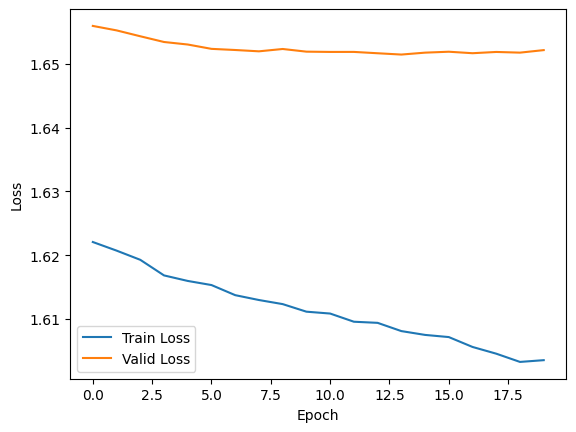

Accuracy: 0.2
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.22      1.00      0.36        10

    accuracy                           0.20        50
   macro avg       0.04      0.20      0.07        50
weighted avg       0.04      0.20      0.07        50



C:\Users\Kevin Liu\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin Liu\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kevin Liu\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

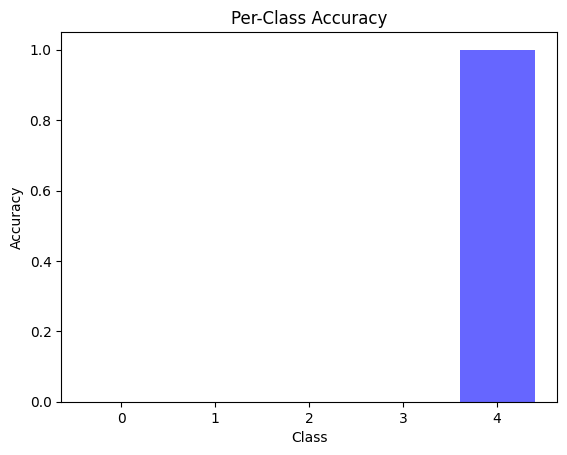